In [1]:
import math
import datetime
import os, sys
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from IPython.display import Audio
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary

import cv2




# local files
sys.path.insert(0, '../')
import pyClient
import sim_utils
import model
from model import Transition
import training_laura

In [2]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment =  pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) # or choose # DummyEnvironment()


# Model parameters
BATCH_SIZE = 12 #original 128
GAMMA = 0.3
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY_steps = 4000 
EPS_DECAY = (EPS_START - EPS_END)/EPS_DECAY_steps
REPLAY_START_SIZE =  1500
TARGET_UPDATE = 10 #episodes
#DEVICE = 'cuda:0'
DEVICE = 'cpu'
MEMORY_CAPACITY = 12000

# agent = model.DoubleDQNAgent(imsize=IMSIZE, 
#                  in_channels=STACK_SIZE,
#                  n_actions=N_ACTIONS,
#                  memory_capacity=MEMORY_CAPACITY,
#                  eps_start=EPS_START,
#                  eps_end=EPS_END,
#                  eps_delta=EPS_DECAY,
#                  gamma_discount = GAMMA,
#                  batch_size = BATCH_SIZE,
#                  device=DEVICE)


# Optimizer Parameters
LR_DQN = 0.0008

# optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

In [3]:
## Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):

        self.imsize = imsize
        if phosphene_resolution is not None:
            
            #phosphene map is expessed as a map of polar angles and eccentricities.
            ecc_coverage   = 30                # in degrees
            polar_coverage =  2 * math.pi      # in radians

            #number of phosphenes placed at each polar angle.
            phosphenes_per_polar = round(math.sqrt(phosphene_resolution))
            phosphenes_per_ecc   = round(math.sqrt(phosphene_resolution))

            noise_scale = 0.14 #standard deviation of the random noise added to phosphene position

            self.imsize = imsize

            ## STEP 2: Establishing of phosphene simulator
            COEFF = 60 # coefficient used to ajust calculated phosphene size to display pixel size - ajust for optimal display
            eff_activation = 1  #diameter of the area in which neurons are activated - in theory this is in mm
                                #(but it is unclear if mm is accurate-relative changes to area should work as intended) 


            self.simulator = sim_utils.PhospheneSimulator(ecc_coverage, 
                                                          polar_coverage, 
                                                          phosphenes_per_polar, 
                                                          phosphenes_per_ecc, 
                                                          noise_scale, 
                                                          coeff = COEFF, 
                                                          eff_activation = eff_activation,
                                                          windowSize = imsize)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw, memory_trace):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
        
        #print(memory_trace.memory.shape)
        #print(torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize).shape)
        
        if self.simulator is not None:
            frame, memory_trace = self.simulator(frame, memory_trace)
    
        #print('frame')
        #print(frame.shape)
        #print('self.imsize')
        #print(self.imsize)
        #print(memory_trace.memory.shape)
        #print(torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize).shape)
        
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize), memory_trace
    
    def count_phosphenes(self):
        if self.simulator is not None:
            getphos = getattr(self.simulator, 'phosphenes')
            count = len(getphos)
        else:
            count = 0
        return count
        
    
img_processing = ImageProcessor

In [4]:
## Training parameters 
#MAX_EPISODES = 800 # number of episodes (an episode ends after agent hits a box)
MAX_EPISODES = 2 # number of episodes (an episode ends after agent hits a box)
MAX_STEPS  = 5e4  # number of optimization steps (each time step the model parameters are updated)
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:True,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Training configuration dictionary
cfg = dict()
# cfg['seed']                     = SEED
# cfg['training_condition']       = TRAINING_CONDITION 
cfg['max_episodes']             = MAX_EPISODES
# cfg['model_path']               = MODEL_PATH
cfg['max_steps']                = MAX_STEPS
cfg['target_update']            = TARGET_UPDATE
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL
cfg['replay_start_size']        = REPLAY_START_SIZE
# cfg['logfile']                  = LOGFILE

for seed in [0,1,2,3,4]:
    for complexity in ['plain', 'complex']:
        for phosphene_resolution in [None, 10, 100, 1000]:
        #currently ajusting resolution works differently so only boolean use for simulator
        #for phosphene_resolution in [None, 50,42,34,26,18,10]:


            # Condition-specific configuration
            cfg['training_condition'] = 0 if complexity == 'plain' else 1 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
            cfg['seed'] = seed
            torch.manual_seed(seed)
            model_name = 'Exp_Laura_{}_phos{}_S{}'.format(complexity,phosphene_resolution,seed)
            print(model_name)
            cfg['logfile'] = 'Out/Exp_Laura/{}_train_stats.csv'.format(model_name)
            cfg['model_path'] = 'Out/Exp_Laura/{}_best_model.pth'.format(model_name)

            # Phosphene simulation
            img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)
            
            #Memory trace parameters
            theta = 0 #Lower bound; represents something like a minimal electrode current to elicit phosphene
            decay = 0.9 #decay rate of memory
            decay_activation = 0.05 #decay of activation
            input_effect = 0.75 #effect of new input on image
            trace_increase = 0.4 #effect of new input on memory trace
            
            n_phosphenes = img_processing.count_phosphenes()
            #total_phosphenes = getattr(img_processing.simulator, 'phosphenes')
            #n_phosphenes = len(total_phosphenes) #number of phosphenes

            #Establish Memory Trace
            memory_trace = sim_utils.Memory(theta, decay, decay_activation, input_effect, trace_increase, n_phosphenes)

            # Re-initialize model and optimizer
            agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 memory_capacity=MEMORY_CAPACITY,
                 eps_start=EPS_START,
                 eps_end=EPS_END,
                 eps_delta=EPS_DECAY,
                 gamma_discount = GAMMA,
                 batch_size = BATCH_SIZE,
                 device=DEVICE)

            optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

            # Start training
            training_laura.train(agent, environment, img_processing, optimizer, memory_trace, cfg)
            print('finished training')

Exp_Laura_plain_phosNone_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
finished training
Exp_Laura_plain_phos10_S0


..\sim_utils.py:159: RuntimeWarning: invalid value encountered in true_divide
  I = np.sum(image_filtered[y-halfs:y+halfs, x-halfs:x+halfs]) / np.power(s,2) #current used for simulation


step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
finished training
Exp_Laura_plain_phos100_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
finished training
Exp_Laura_plain_phos1000_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
finished training
Exp_Laura_complex_phosNone_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
finished training
Exp_Laura_complex_phos10_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
finished training
Exp_Laura_complex_phos100_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
finished training
Exp_Laura_complex_

## Debugging:

#### Visualize replay memory 

In [5]:
# EXAMPLES = 10

# i = 0
# bad_choices = [(state, action, next_state,reward) for (state, action, next_state,reward) in agent.memory.memory]# if reward<0 and action ==0]
# # for state, action, next_state, reward in agent.memory.memory[:EXAMPLES]:
# for state, action, next_state, reward in bad_choices[:EXAMPLES]:
#     i+=1
    
#     plt.figure(figsize = (10,10), dpi=200)
#     img = torch.cat([state[0,t,...] for t in range(STACK_SIZE)],dim=1)
#     if next_state is not None:
#         img = torch.cat([img, next_state[0,-1,...]],dim=1)
#         plt.axvline(x=STACK_SIZE*IMSIZE,color='r')
#     plt.imshow(img.detach().cpu().numpy())
#     plt.title('Action: {}, Reward {}'.format(action.item(),reward.item()))
#     plt.axis('off')
#     plt.ylabel('frames >')
#     plt.xlabel('state | next state')
#     plt.show()
    
# # plt.tight_layout()


#### Inspecting q-value predictions

In [6]:
# state_action_values, expected_state_action_values = agent.forward()
# transitions = agent.memory.sample(agent.batch_size)
# # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
# # detailed explanation). This converts batch-array of Transitions
# # to Transition of batch-arrays.
# batch = Transition(*zip(*transitions))

# # Compute a mask of non-final states and concatenate the batch elements
# # (a final state would've been the one after which simulation ended)
# non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
#                                       batch.next_state)), device=agent.device, dtype=torch.bool)
# non_final_next_states = torch.cat([s for s in batch.next_state
#                                             if s is not None])
# state_batch = torch.cat(batch.state)
# action_batch = torch.cat(batch.action)
# reward_batch = torch.cat(batch.reward)

# # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
# # columns of actions taken. These are the actions which would've been taken
# # for each batch state according to policy_net
# pred = agent.policy_net(state_batch)

# EXAMPLES = 50

# actions = action_batch[:EXAMPLES].detach().cpu().numpy()
# rewards = reward_batch[:EXAMPLES].detach().cpu().numpy()
# predicted = pred[:EXAMPLES].detach().cpu().numpy().squeeze()
# obtained = np.zeros((EXAMPLES,3))
# for i in range(EXAMPLES):
#     obtained[i,actions[i]] = rewards[i]

# plt.figure(figsize=(10,10),dpi=100)
# plt.subplot(1,2,1)
# plt.imshow(predicted)
# plt.subplot(1,2,2)
# plt.imshow(obtained)
# plt.show()

#### Visualize an episode

In [10]:
import utils 

# Reset environment at start of episode
seed = torch.randint(250,(1,)).item()
_, _, _ = environment.setRandomSeed(seed)
_, _, _ = environment.reset(cfg['training_condition'])

# Create an empty frame stack and fill it with frames
frame_stack = utils.FrameStack(stack_size=cfg['stack_size'] )
for _ in range(cfg['stack_size'] ):
    _, _, frame_raw = environment.step(0)
    frame, memory_trace = img_processing(frame_raw, memory_trace)
    frame.to(agent.device) 
    state = frame_stack.update_with(frame)

In [ ]:
# for t in count(): 

#     agent.policy_net.eval()
#     # Agent performs a step (based on the current state) and obtains next state
#     action = agent.select_action(state)
#     end, reward, frame_raw = environment.step(action.item())
#     agent_died = cfg['reset_upon_end_signal'][end] # or side_steps > cfg['reset_after_nr_sidesteps']
#     frame = img_processing(frame_raw).to(agent.device)
#     next_state = frame_stack.update_with(frame) if not agent_died else None
#     pred = agent.policy_net(state).argmax(axis=1)
    
#     # Interpret reward signal
#     if reward > 100:
#         reward = -(reward -100)
#     reward /= 10
    
#     # Visualize state and print pred, action and reward
#     plt.figure(figsize = (10,10), dpi=200)
#     img = torch.cat([state[0,t,...] for t in range(STACK_SIZE)],dim=1)
#     if next_state is not None:
#         img = torch.cat([img, next_state[0,-1,...]],dim=1)
#         plt.axvline(x=STACK_SIZE*IMSIZE,color='r')
#     plt.imshow(img.detach().cpu().numpy())
#     plt.title('Action: {}, Reward {}'.format(action.item(),reward))
#     plt.axis('off')
#     plt.ylabel('frames >')
#     plt.xlabel('state | next state')
#     plt.show()
#     print('Pred: {}'.format(pred.item()))
#     print('Action: {}'.format(action.item()))
#     print('Reward: {}\n'.format(reward))

#     # the episode ends here if agent performed any 'lethal' action (specified in RESET_UPON_END_SIGNAL)
#     if agent_died:
#         break
#     else:
#         state = next_state


#### Toy environment for debugging

In [ ]:
# class DummyEnvironment:
#     def __init__(self, ip = "127.0.0.1", port = 13000, size = 128, channels=16):
#         self.size = size
#         self.channels = channels
#         self._maxSteps = 100
#         self.reset()
 
#     def reset(self, kind=0):
#         self._state = 1
#         self._steps = 0
#         return self._receive()

#     def step(self, action):
#         self._state = -self._state
#         self._steps += 1
#         return self._receive(action)
    
#     def setRandomSeed(self, action):
#         return self._receive()

#     def _receive(self,action=0):
#         end    = 0 if self._steps < self._maxSteps else 3
#         reward = {0:-self._state, 1:self._state, 2:-2}[action]
#         state  = [150-100*self._state for _ in range(262144)] # raw state
#         return end, reward, state
    
#     def state2arrays(self,state):
#         if self.channels == 3:
#             return {'colors' : self.state2usableArray(state),}
        
#         else:
#             state  = np.array(state, "uint8").reshape(self.size, self.size, self.channels)
#             arrays = {'colors' : state[...,:3],
#                     'objseg' : state[...,3:6],
#                     'semseg': state[...,6:9],
#                     'normals'   : state[...,9:12],
#                     'flow'   : state[...,12:15],
#                     'depth'  : state[...,15]}
#             return arrays
    
#     def state2usableArray(self, state):
#         return np.array(state, "uint8").reshape(self.size, self.size, 16)[...,:3]

## Validation:

#### Fast evaluation of trained model

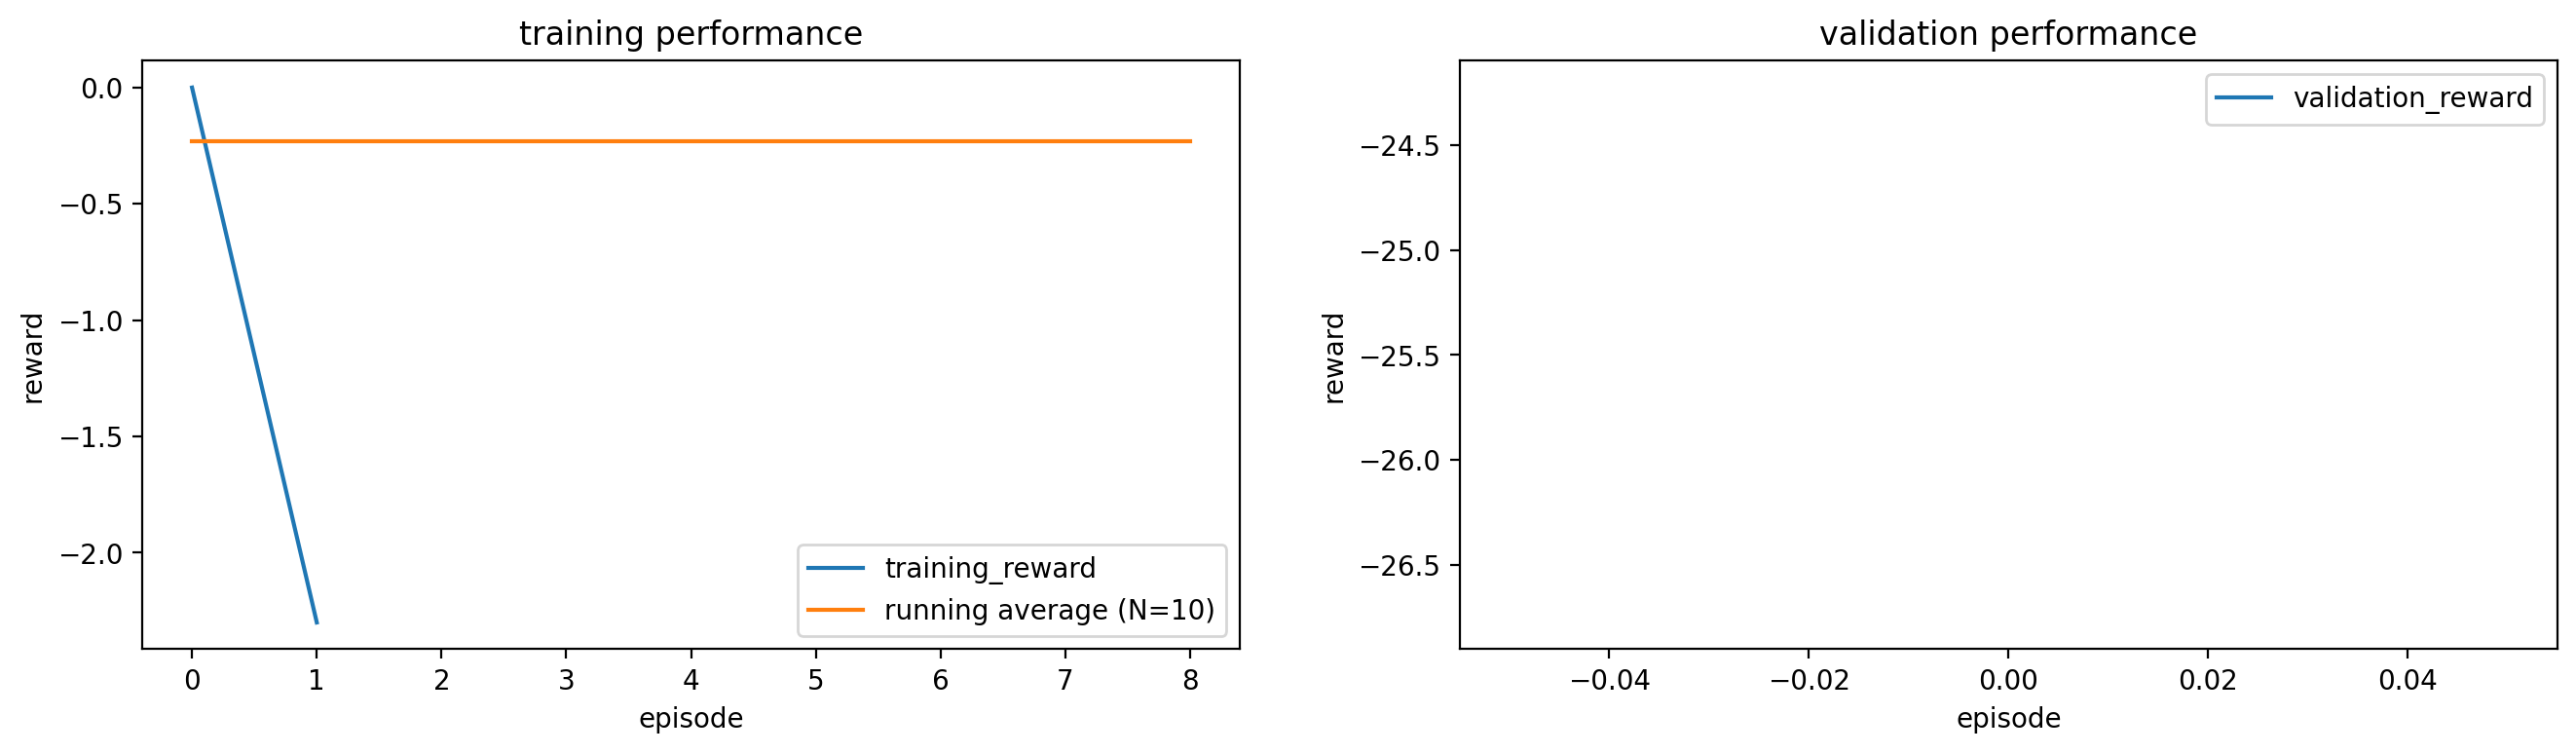

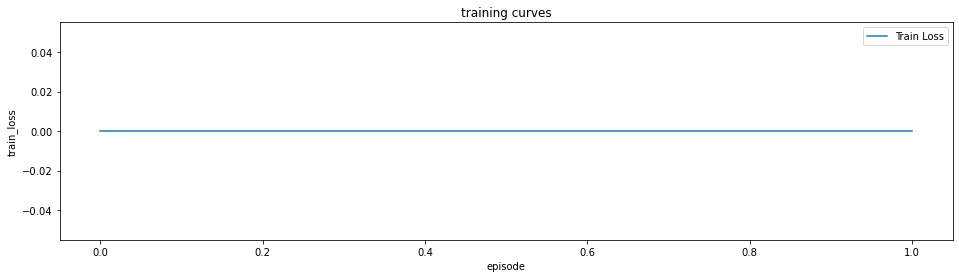

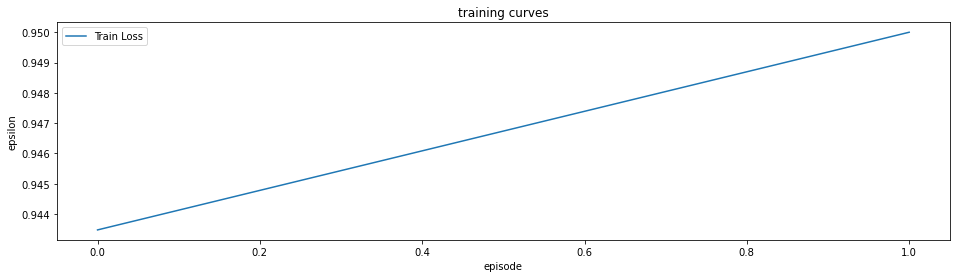

In [11]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MODEL_NAME = 'Exp_Laura_plain_phosNone_S0'

stats = pd.read_csv('./Out/Exp_Laura/{}_train_stats.csv'.format(MODEL_NAME))

plt.figure(figsize = (16,4),dpi=200)
plt.subplot(1,2,1)
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='reward')
plt.plot(np.convolve(stats.loc[stats.validation==0].reward,np.ones(10)/10,mode='valid'))
plt.title('training performance')
plt.legend(['training_reward', 'running average (N=10)'])
plt.subplot(1,2,2)
sns.lineplot(data= stats.loc[stats.validation==1],x='episode', y='reward')
plt.title('validation performance')
plt.legend(['validation_reward'])
plt.show()

plt.figure(figsize = (16,4))
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='train_loss')
plt.title('training curves')
plt.legend(['Train Loss'])

plt.figure(figsize = (16,4))
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='epsilon')
plt.title('training curves')
plt.legend(['Train Loss'])

### Further testing and evaluation:

In [12]:
import torch
import cv2
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

# # local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition
from testing_laura import test

#### Run models on test environment:

In [13]:
## Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):

        self.imsize = imsize
        if phosphene_resolution is not None:
            
            #phosphene map is expessed as a map of polar angles and eccentricities.
            ecc_coverage   = 30                # in degrees
            polar_coverage =  2 * math.pi      # in radians

            #number of phosphenes placed at each polar angle.
            phosphenes_per_polar = round(math.sqrt(phosphene_resolution))
            phosphenes_per_ecc   = round(math.sqrt(phosphene_resolution))

            noise_scale = 0.14 #standard deviation of the random noise added to phosphene position

            self.imsize = imsize

            ## STEP 2: Establishing of phosphene simulator
            COEFF = 60 # coefficient used to ajust calculated phosphene size to display pixel size - ajust for optimal display
            eff_activation = 1  #diameter of the area in which neurons are activated - in theory this is in mm
                                #(but it is unclear if mm is accurate-relative changes to area should work as intended) 


            self.simulator = sim_utils.PhospheneSimulator(ecc_coverage, 
                                                          polar_coverage, 
                                                          phosphenes_per_polar, 
                                                          phosphenes_per_ecc, 
                                                          noise_scale, 
                                                          coeff = COEFF, 
                                                          eff_activation = eff_activation,
                                                          windowSize = imsize)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw, memory_trace):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
   
        if self.simulator is not None:
            frame, memory_trace = self.simulator(frame, memory_trace)
    
      
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize), memory_trace
    
    def count_phosphenes(self):
        if self.simulator is not None:
            getphos = getattr(self.simulator, 'phosphenes')
            count = len(getphos)
        else:
            count = 0
        return count
        
    
img_processing = ImageProcessor

In [14]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 

# Model parameters
BATCH_SIZE = 12 #original 128
#DEVICE = 'cuda:0'
DEVICE = 'cpu'

agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)


## Testing parameters 
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:False,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Testing configuration dictionary
cfg = dict()
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL

test_data = []
for seed in [0,1,2,3,4]:
    for complexity in ['plain', 'complex']:
        for phosphene_resolution in [None, 10, 100, 1000]:
            
            # Condition-specific configuration
            cfg['training_condition']       = 2 if complexity == 'plain' else 3 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
            model_name = 'Exp_Laura_{}_phos{}_S{}'.format(complexity, phosphene_resolution,seed)
            model_path = 'Out/Exp_Laura/{}_best_model.pth'.format(model_name)
            print(model_name)
            
            # Phosphene simulation
            img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)
            
            #Memory trace parameters
            theta = 0 #Lower bound; represents something like a minimal electrode current to elicit phosphene
            decay = 0.9 #decay rate of memory
            decay_activation = 0.05 #decay of activation
            input_effect = 0.75 #effect of new input on image
            trace_increase = 0.4 #effect of new input on memory trace
            
            n_phosphenes = img_processing.count_phosphenes()
            #total_phosphenes = getattr(img_processing.simulator, 'phosphenes')
            #n_phosphenes = len(total_phosphenes) #number of phosphenes

            #Establish Memory Trace
            memory_trace = sim_utils.Memory(theta, decay, decay_activation, input_effect, trace_increase, n_phosphenes)

            

            # Re-initialize model and optimizer
            agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)
            agent.policy_net.load_state_dict(torch.load(model_path,map_location=DEVICE))
            
            # Start training
            #training_laura.train(agent, environment, img_processing, optimizer, memory_trace, cfg)
            #print('finished training')

            # Testing
            conditions = {'complexity': complexity, 'phosphene_resolution': phosphene_resolution, 'seed' : seed}
            results = test(agent, environment, img_processing, memory_trace, cfg)
            test_data.append({**conditions,**results})
data = pd.DataFrame(test_data)
data.to_csv('Out/Exp_Laura/_test_results.csv', index=False)

Exp_Laura_plain_phosNone_S0
Exp_Laura_plain_phos10_S0


FileNotFoundError: [Errno 2] No such file or directory: 'Out/Exp_Laura/Exp_Laura_plain_phos10_S0_best_model.pth'

In [ ]:
test_data = pd.read_csv('./Out/Exp_Laura/_test_results.csv') 
test_data

In [ ]:
sns.lineplot(data=test_data,x='phosphene_resolution', y='box_collisions', hue='complexity')
plt.show()
sns.lineplot(data=test_data,x='phosphene_resolution', y='wall_collisions', hue='complexity')
plt.show()
sns.lineplot(data=test_data,x='phosphene_resolution', y='cumulative_reward', hue='complexity')

#### Training and validation curves

In [ ]:
all_stats = pd.DataFrame()
best_stats = pd.DataFrame()
for complexity in ['plain', 'complex']:
    for phosphene_resolution in [None, 50,42,34,26,18,10]:
        for seed in [0,1,2,3,4]:
            model_name = 'Exp_Laura_{}_phos{}_S{}'.format(complexity, phosphene_resolution,seed)
            train_csv = './Out/Exp_Laura/{}_train_stats.csv'.format(model_name)
            train_stats = pd.read_csv(train_csv)
            train_stats['complexity'] = complexity
            train_stats['resolution'] = phosphene_resolution
            train_stats['seed'] = seed
            train_stats['model_name'] = model_name
            
            # append all rows
            all_stats = all_stats.append(train_stats,ignore_index=True)
            
            # append only best-performing validation row
            val = train_stats.loc[train_stats.validation==1].reset_index()
            best_stats = best_stats.append(val.iloc[[val.reward.idxmax()]], ignore_index=True)


In [ ]:
MODEL_NAME = 'Exp_Laura_plain_phos18_S2'

stats = all_stats.loc[all_stats.model_name==MODEL_NAME]

plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='reward')
plt.plot(np.convolve(stats.loc[stats.validation==0].reward,np.ones(10)/10,mode='valid'))
plt.title('training performance')
plt.legend(['training_reward', 'running average (N=10)'])
plt.subplot(1,2,2)
sns.lineplot(data= stats.loc[stats.validation==1],x='episode', y='reward')
plt.title('validation performance')
plt.legend(['validation_reward'])
plt.show()


In [ ]:
for y in ['reward', 'step_count', 'wall_collisions', 'box_collisions', 'endless_loops']:
    sns.lineplot(data=best_stats, x='resolution',y=y,hue='complexity')
    plt.show()